# Catégorisez automatiquement des questions
## Analyse exploratoire des données (Stack Overflow)
### OpenClassRooms

**réalisation** : Fabrice Deprez
**date**        : 05/20223

a partir de l'API Stack Overflow, nous allons récupérer un ensemble de données que nous allons étudier
[Data](https://data.stackexchange.com/stackoverflow/query/new)

la requête doit avoir :

   * un nombre de vue 
   * des commentaires 
   * des réponses
   * des mise en favoris
   * un score significatif
   * au moins 5 tags

`SELECT TOP 500000 CreationDate, Title, Body, Tags, Id, Score, ViewCount, FavoriteCount, AnswerCount
FROM Posts 
WHERE CreationDate, ViewCount > 10 
AND FavoriteCount > 10
AND Score > 5 AND 
AnswerCount > 0 
AND LEN(Tags) - LEN(REPLACE(Tags, '<','')) >= 5`

In [1]:
#!pip install matplotlib

#### Importations

In [43]:
# Import des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import os
import datetime as dt
import scipy.stats as st
import missingno as msno
import warnings
#warnings.filterwarnings(action='ignore',category=FutureWarning)
# Désactiver tous les avertissements
warnings.filterwarnings("ignore")

import random
from IPython.display import Markdown, display

from nltk.tokenize import word_tokenize
os.environ['OMP_NUM_,nmTHREADS'] = '1'

import transformers
from transformers import BertTokenizer as BTokenizer
#from transformers import *
os.environ["TF_KERAS"]='1'


%pylab 
%matplotlib inline
import seaborn as sns



import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re as regex  # Renommer la bibliothèque re

# Télécharger les ressources nécessaires pour NLTK
nltk.download('stopwords')
nltk.download('punkt')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

Using matplotlib backend: TkAgg
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kaneda\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kaneda\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# -- cette fonction permet d'afficher du markdown dans la réponse de l'exécution d'un code
def markdown(string):
    display(Markdown(string))
    
# -- cette fonction permet d'afficher les informations complètes d'un dataframe
def show_informations(df, title):
    markdown(f'*** {title} ***')
    print("Total: {} enregistrements pour {} variables".format(df.shape[0],df.shape[1]))
    print(df.columns)
    print(df.info(verbose= True, show_counts=True))
    msno.bar(df)     
    
def visualize_continuous_variable(data, col, bins='sturges'):
    """
    Diagramme de distribution, diagramme en boîte et figures de distribution statistique
    
    Args: 
        data(DataFrame): Nom du dataframe 
        col(String): Nom de la colonne pour plot
        
    Returns:
        Graphiques et figures de distribution des variables
    """
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(50,10))
    
    ax[0].hist(data[col], bins=bins, edgecolor='black')
    ax[0].set_xlabel(f"{col}")
    ax[0].set_ylabel("Nombre d'observations")
    ax[0].set_title(f"Histogramme de la variable {col}")
    
    sns.boxplot(data=data, x=col, ax=ax[1])
    ax[1].set_xlabel(f"{col}")
    ax[1].set_ylabel("Nombre d'observations")
    ax[1].set_title(f"Boîte à moustaches de la variable {col}")
    
    plt.show()
    
    print("\n" + "-" * 50 + "\n")
    print(f"Indicateurs statistiques de distribution de la variable {col}:")
    display(data[col].describe())
    
    
#def visualize_continuous_variable(data, col, bins='sturges'):
#    """
#    Diagramme de distribution, diagramme en boîte et figures de distribution statistique
    
#    Args: 
#        data(DataFrame): Nom du dataframe 
        
#        col(String): Nom de la colonne pour plot
        
#    Returns:
#        Graphiques et figures de distribution des variables
#    """
    
#    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(50,10))
    
#    sns.histplot(data=data, x=col, bins='sturges', kde=True, ax=ax[0])
#    ax[0].set_xlabel(f"{col}")
#    ax[0].set_ylabel("Nombre d'observations")
#    ax[0].set_title(f"Histograme de la variable {col}")
    
#    sns.boxplot(data=data, x=col)
#    ax[1].set_xlabel(f"{col}")
#    ax[1].set_ylabel("Nombre d'oservations")
#    ax[1].set_title(f"Boîte à moustaches de la variable {col}")
#    plt.show()
    
#    print("\n" + "-" * 50 + "\n")
#    print(f"Indicateurs statistiques de distribution de la variable {col}:")
#    display(data[col].describe())    
    
def plot_boxplot(data, col):
    """
    Affiche un diagramme en boîte (boxplot) pour une colonne spécifiée du DataFrame.
    
    Args:
        data (DataFrame): Le DataFrame contenant les données.
        col (str): Le nom de la colonne à représenter.
    """
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=data, y=col)
    plt.title(f"Diagramme en boîte de la colonne {col}")
    plt.xlabel(col)
    plt.ylabel("Valeurs")
    plt.show()

def display_formatted_comments(data, col):
    """
    Affiche les commentaires formatés pour une meilleure lisibilité.
    
    Args:
        data (DataFrame): Le DataFrame contenant les données.
        col (str): Le nom de la colonne contenant les commentaires.
    """
    for comment in data[col]:
        display(Markdown(f"**Commentaire:**\n\n{comment}\n\n{'-' * 50}\n"))
    
def clean_text(text):
    # Supprimer les balises HTML
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Supprimer la ponctuation et les caractères spéciaux
    text = re.sub('[^a-zA-Z0-9]', ' ', text)

    # Mettre en minuscule
    text = text.lower()

    # Remplacer les mots spécifiques
    text = re.sub(r'\bC\+\+\b', 'cplusplus', text)
    #attention a casesentivie
    text = re.sub(r'\b5G\b', 'fiveg', text, flags=re.IGNORECASE)
    text = re.sub(r'\b4G\b', 'fourg', text, flags=re.IGNORECASE)
    # Ajoutez d'autres remplacements si nécessaire pour les mots spécifiques

    # Supprimer les mots vides
    stop_words = set(stopwords.words('english'))
    tokens = nltk.word_tokenize(text)
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatisation
    lemmatizer = nltk.WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Rejoindre les tokens en une chaîne de caractères
    cleaned_text = ' '.join(tokens)

    return cleaned_text

In [4]:
data = pd.read_csv(f'./data/QueryResults.csv', sep=',', low_memory=False, encoding='utf-8')

*** Resultats StackOverflow ***

Total: 50000 enregistrements pour 9 variables
Index(['CreationDate', 'Title', 'Body', 'Tags', 'Id', 'Score', 'ViewCount',
       'FavoriteCount', 'AnswerCount'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CreationDate   50000 non-null  object
 1   Title          50000 non-null  object
 2   Body           50000 non-null  object
 3   Tags           50000 non-null  object
 4   Id             50000 non-null  int64 
 5   Score          50000 non-null  int64 
 6   ViewCount      50000 non-null  int64 
 7   FavoriteCount  50000 non-null  int64 
 8   AnswerCount    50000 non-null  int64 
dtypes: int64(5), object(4)
memory usage: 3.4+ MB
None


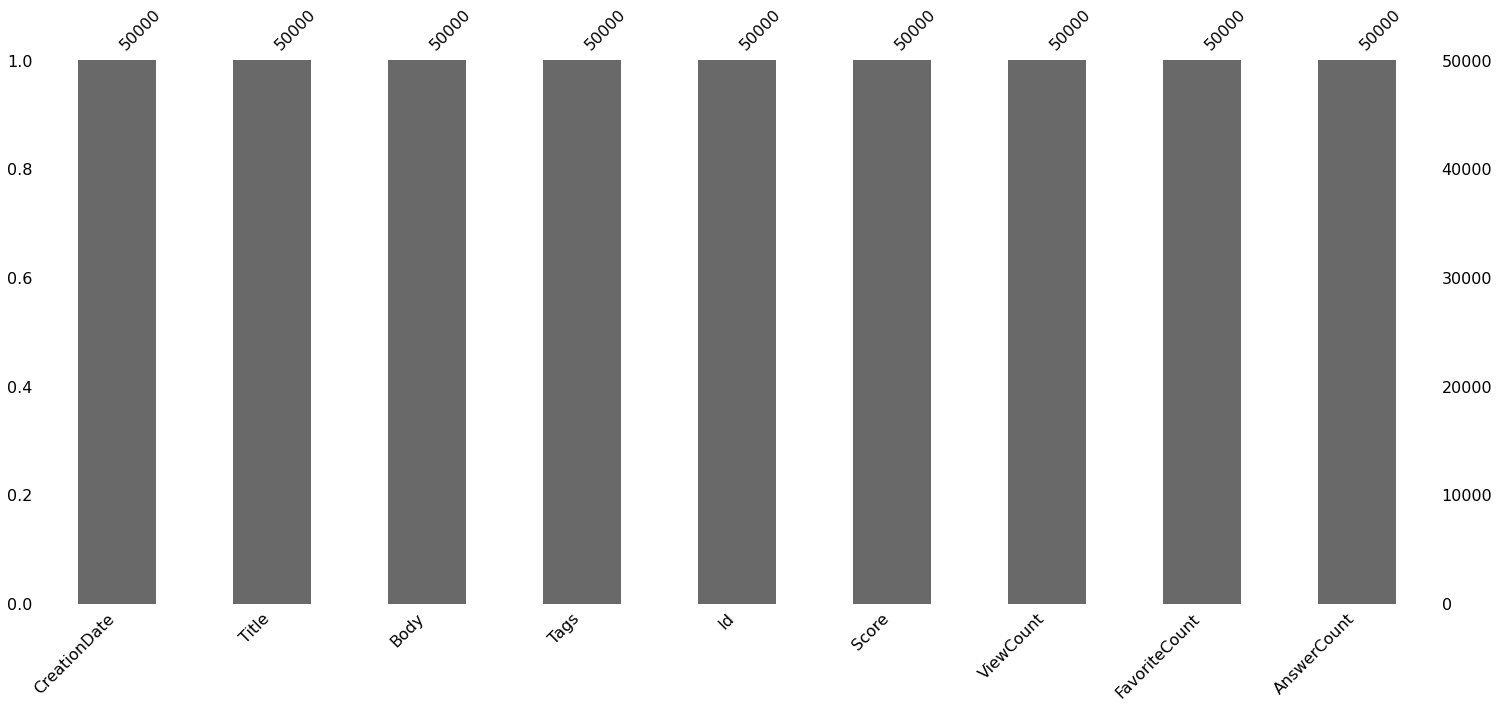

In [5]:
# -- On affiche ici les informations concernant CUSTOMERS
show_informations(data, 'Resultats StackOverflow')

In [6]:
data.sample(5, random_state=1)

,CreationDate,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount
26247,2014-06-11 21:16:21,Google Analytics for iOS - Sending Custom Even...,<p>I decided to use Google Analytics over Flur...,<ios><objective-c><iphone><google-analytics><f...,24172712,11,7109,0,3
35067,2014-01-30 23:19:52,Spring Data Rest Pageable Child Collection,<p>I have an @Entity called User. It has a Set...,<spring><hibernate><spring-data><spring-data-j...,21469538,12,3948,0,1
34590,2019-10-19 12:14:11,How to right-align item labels in a custom Swi...,<p>I have the following Cocoa form:</p>\n\n<pr...,<forms><macos><cocoa><swiftui><appkit>,58463568,11,1911,0,2
16668,2014-09-10 12:48:51,How do I install dependencies when cross compi...,<p>I've successfully created a ghc cross compi...,<haskell><raspberry-pi><cross-compiling><ghc><...,25765893,15,1490,0,1
12196,2013-11-08 06:53:09,"Android4.4 can not handle sms intent with ""vnd...",<p>My application has a button to start defaul...,<java><android><android-intent><sms><android-4...,19853220,16,15043,0,4


In [7]:
#!pip install --upgrade pandas

### Analyse statistiques des variables numériques

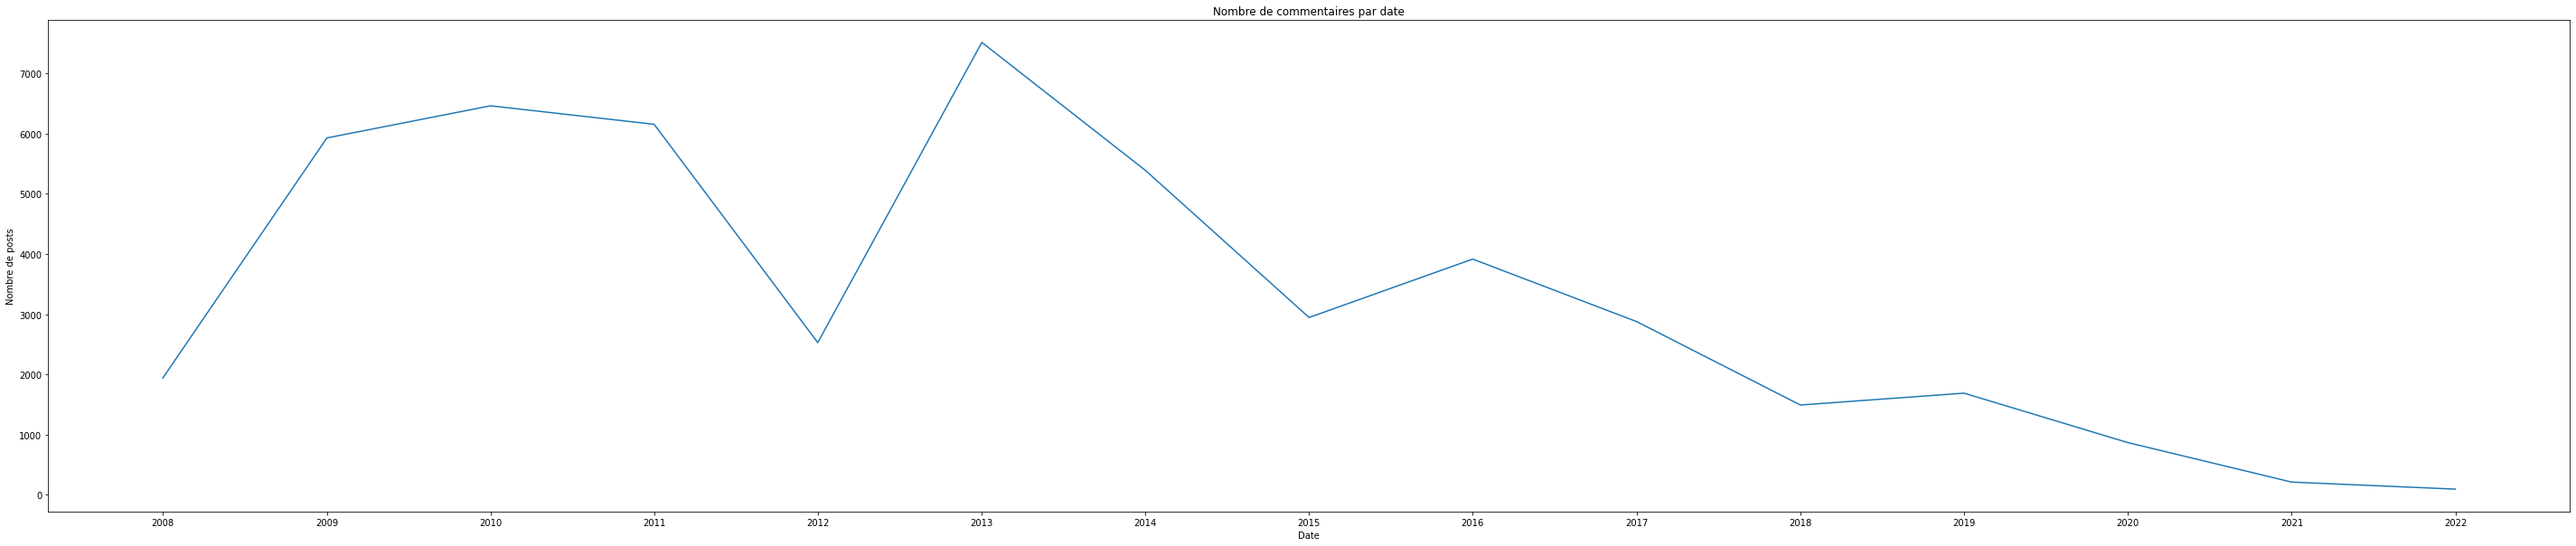

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(50, 10))
data['CreationDate'] = pd.to_datetime(data['CreationDate'])
CreationDateByDay = data['CreationDate'].dt.date.value_counts()

# Convertir les dates en objets datetime
dates = pd.to_datetime(CreationDateByDay.index)

# Calculer la somme des valeurs pour chaque année
values = CreationDateByDay.groupby(dates.year).sum()

# Création de l'abscisse avec une fréquence d'un an
years = pd.date_range(start=str(dates.min().year), end=str(dates.max().year), freq='YS')

# Tracer la courbe
ax.plot(years, values)

# Format de l'axe des dates
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

ax.set_xlabel("Date")
ax.set_ylabel("Nombre de posts")
ax.set_title("Nombre de commentaires par date")

plt.show()

il y a une baisse significative des posts après 2018, si on filtre par date, cela va pénaliser les publications les plus récentes

### visualisation des variables continues

### SCORE

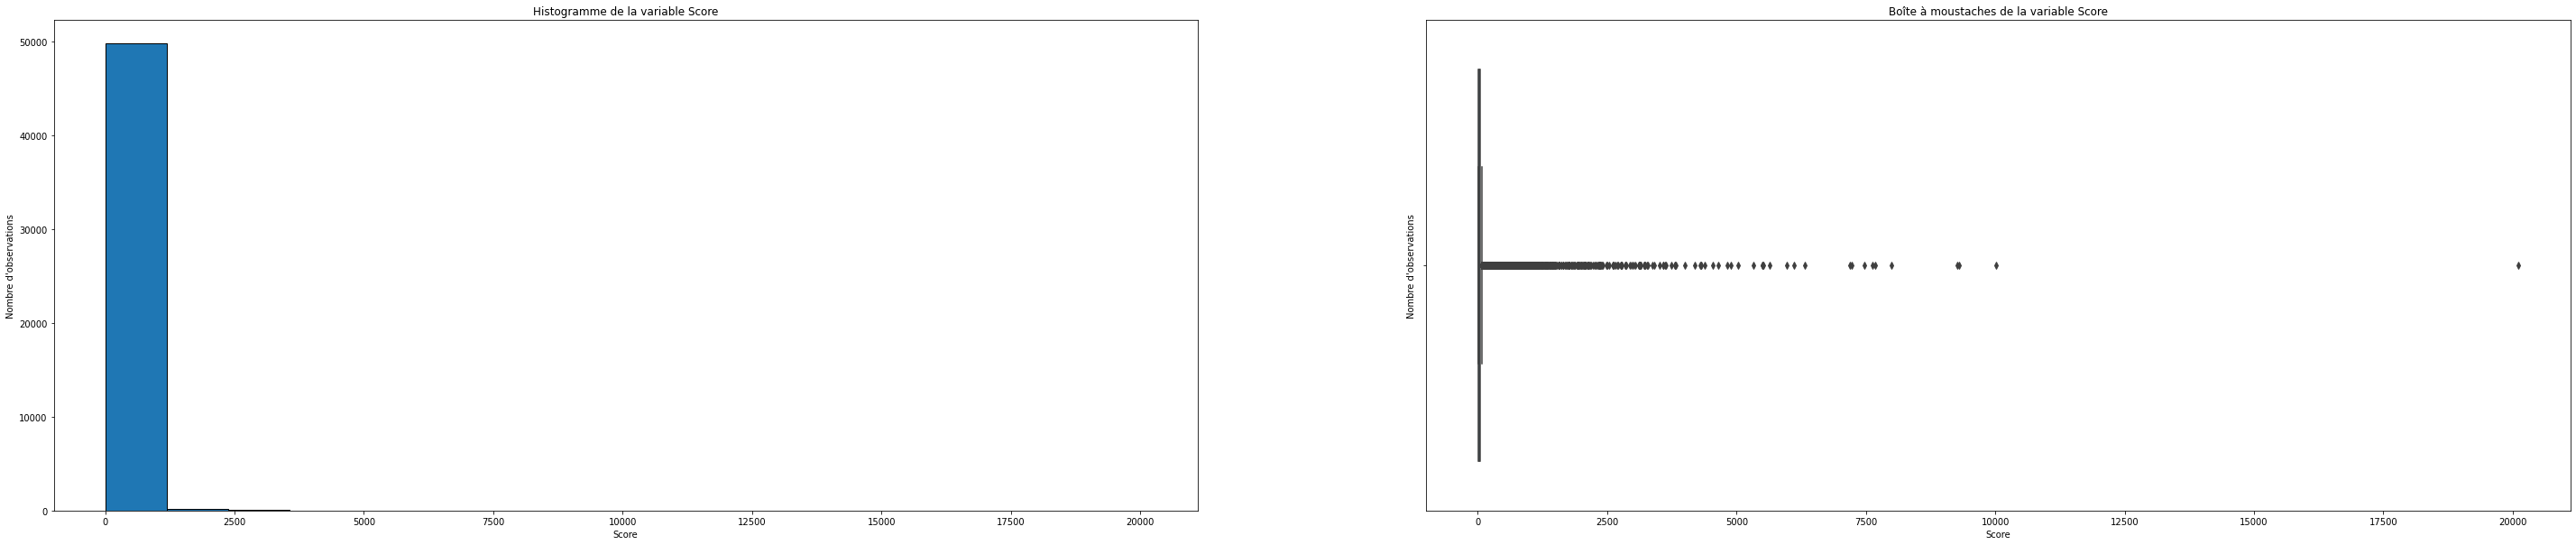


--------------------------------------------------

Indicateurs statistiques de distribution de la variable Score:


count    50000.000000
mean        56.268960
std        230.600982
min         11.000000
25%         14.000000
50%         20.000000
75%         39.000000
max      20107.000000
Name: Score, dtype: float64

In [9]:
visualize_continuous_variable(data=data, col='Score')

### ViewCount

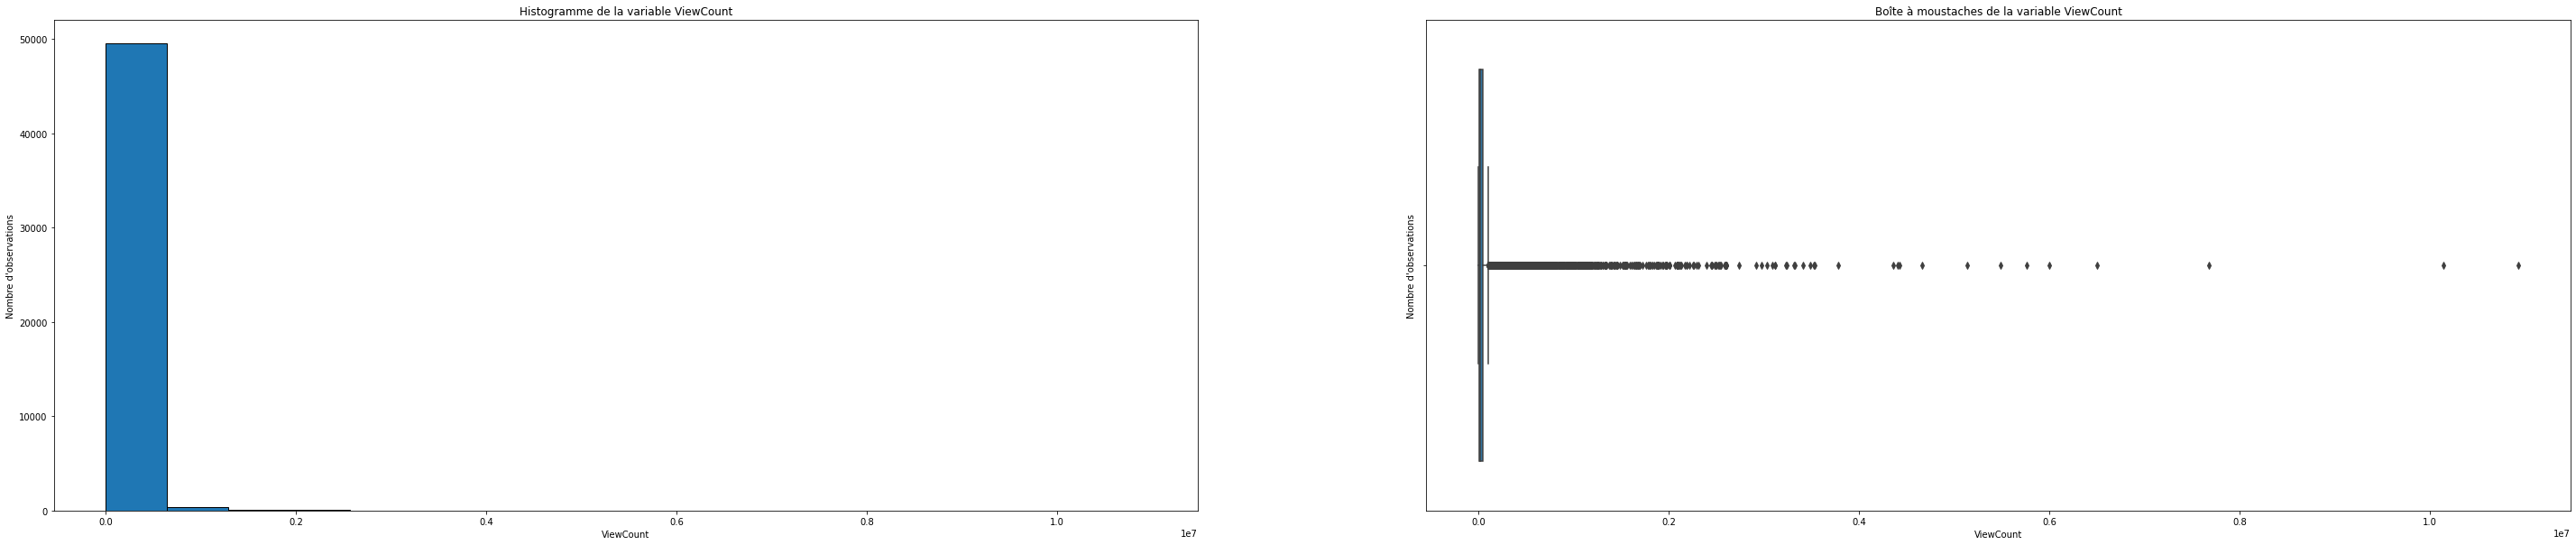


--------------------------------------------------

Indicateurs statistiques de distribution de la variable ViewCount:


count    5.000000e+04
mean     5.714557e+04
std      1.789337e+05
min      1.050000e+02
25%      8.250750e+03
50%      2.014750e+04
75%      4.836800e+04
max      1.092895e+07
Name: ViewCount, dtype: float64

In [10]:
visualize_continuous_variable(data=data, col='ViewCount')

### AnswerCount

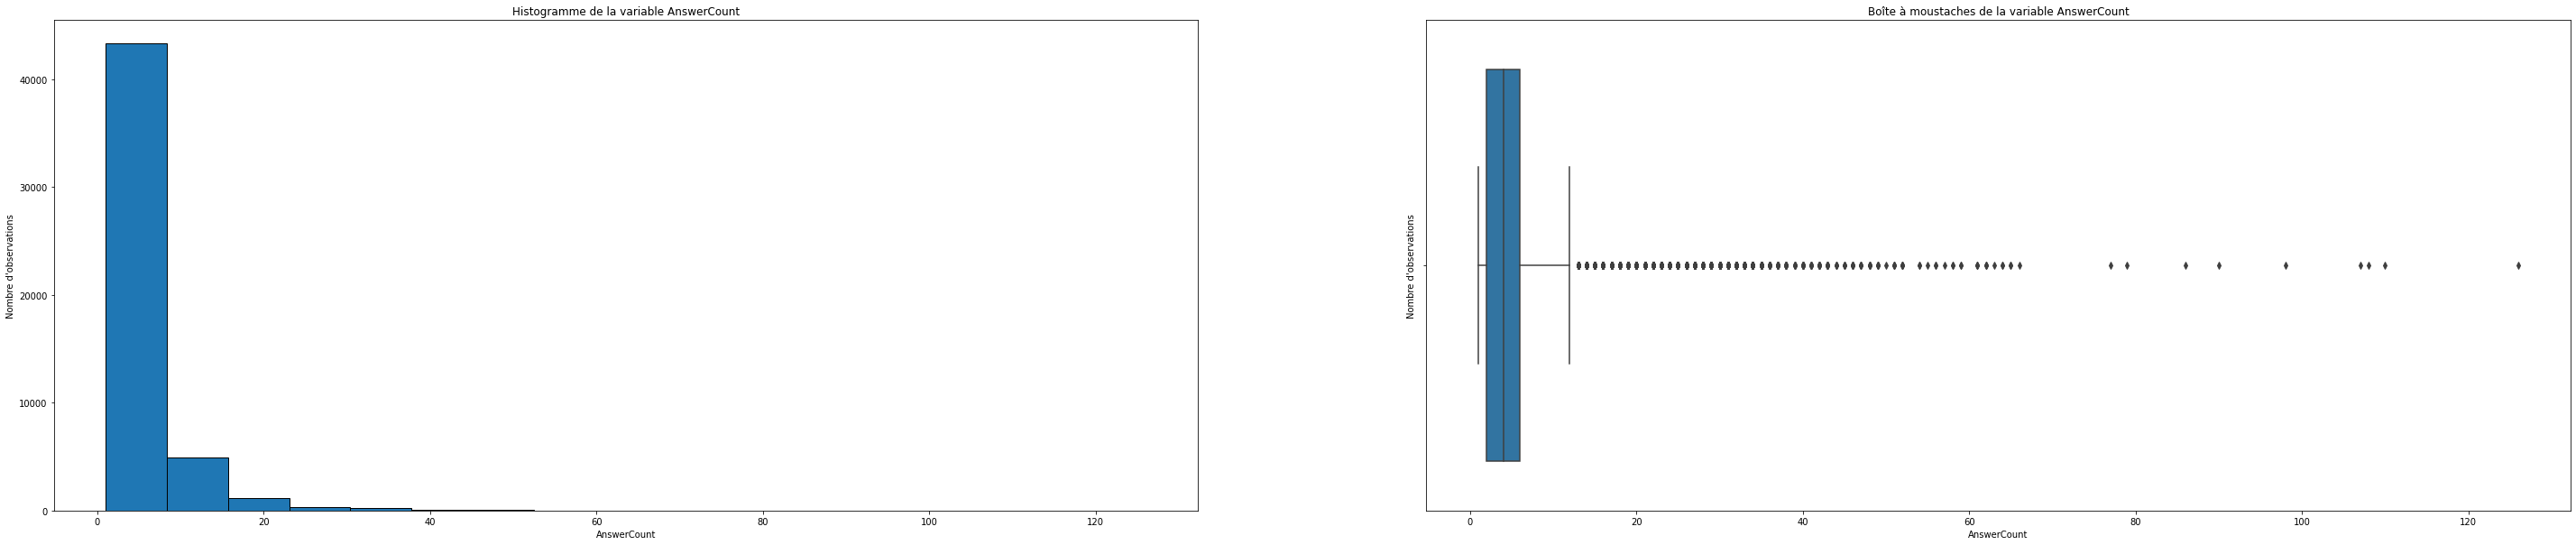


--------------------------------------------------

Indicateurs statistiques de distribution de la variable AnswerCount:


count    50000.000000
mean         5.023420
std          5.039684
min          1.000000
25%          2.000000
50%          4.000000
75%          6.000000
max        126.000000
Name: AnswerCount, dtype: float64

In [11]:
visualize_continuous_variable(data=data, col='AnswerCount')

### FavoriteCount

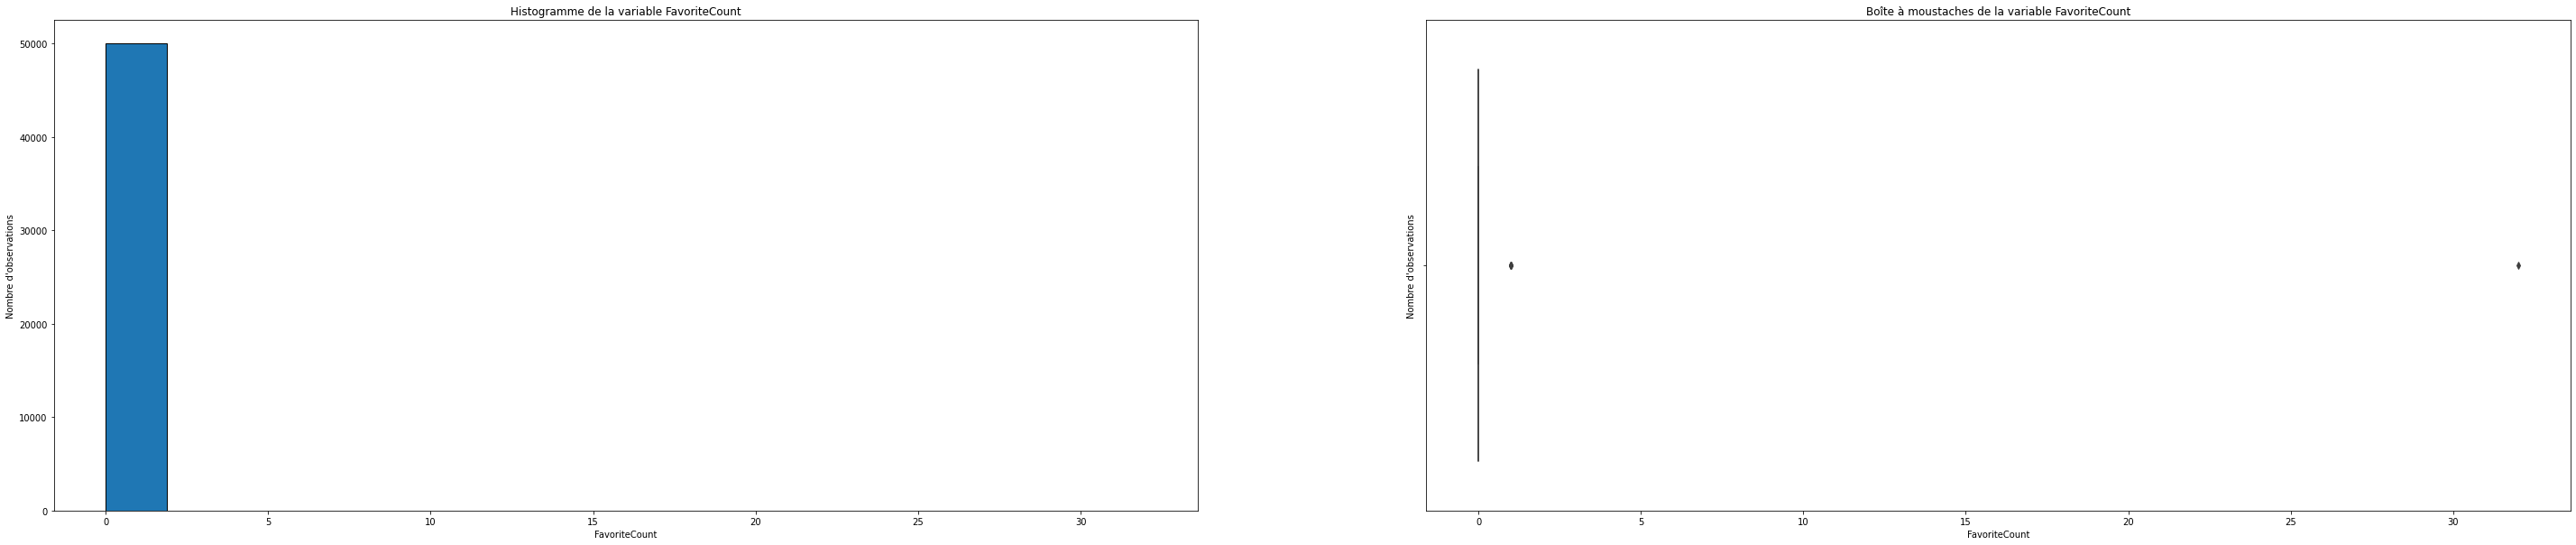


--------------------------------------------------

Indicateurs statistiques de distribution de la variable FavoriteCount:


count    50000.000000
mean         0.000760
std          0.143526
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         32.000000
Name: FavoriteCount, dtype: float64

In [12]:
# Supprimer les valeurs manquantes
#data = data.dropna(subset=['FavoriteCount'])

# Convertir la colonne en type numérique
#data['FavoriteCount'] = data['FavoriteCount'].astype(float)

# Gérer les valeurs aberrantes (par exemple, supprimer les valeurs supérieures à un certain seuil)
#threshold = 1000  # Définir le seuil des valeurs aberrantes
#data = data[data['FavoriteCount'] <= threshold]

visualize_continuous_variable(data=data, col='FavoriteCount')

In [13]:
# Calculer le nombre de valeurs supérieures à zéro dans la colonne 'FavoriteCount'
count_gt_zero = (data['FavoriteCount'] > 0).sum()

# Afficher le résultat
print("Nombre de valeurs supérieures à zéro : ", count_gt_zero)

Nombre de valeurs supérieures à zéro :  7


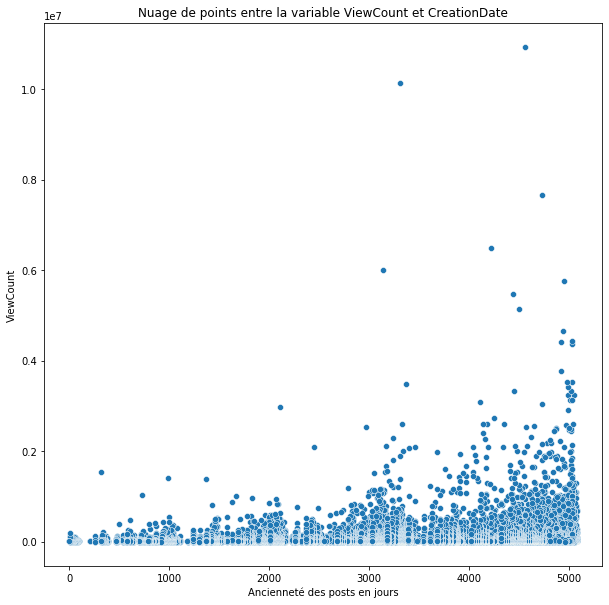

In [14]:
last_post = data["CreationDate"].max()
data["CreationDateTimeDelta"] = last_post - data["CreationDate"]
data["CreationDateTimeDelta"] = data["CreationDateTimeDelta"].dt.days

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
sns.scatterplot(data=data, x="CreationDateTimeDelta", y="ViewCount", ax=ax)
ax.set_xlabel("Ancienneté des posts en jours")
ax.set_label("Nombre de vues")
ax.set_title("Nuage de points entre la variable ViewCount et CreationDate")
plt.show()

In [15]:
#!pip install seaborn

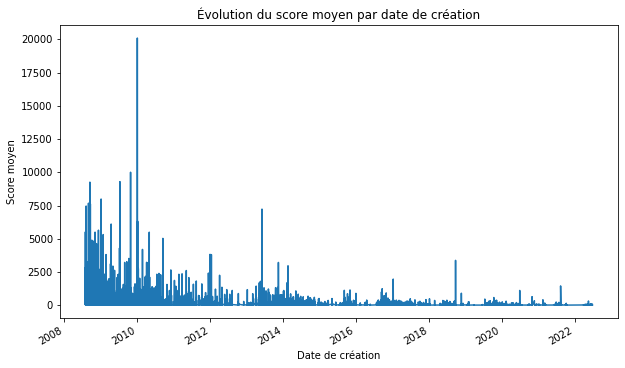

In [16]:
# Effectuer un groupby sur la colonne 'CreationDate' et calculer la moyenne des scores pour chaque date
#score_by_date = data.groupby('CreationDate')['Score'].mean()

# Créer le graphique linéaire
#fig, ax = plt.subplots(figsize=(10, 6))
#sns.lineplot(data=score_by_date, x=score_by_date.index, y=score_by_date.values, ax=ax)
#ax.set_xlabel("Date de création")
#ax.set_ylabel("Score moyen")
#ax.set_title("Évolution du score moyen par date de création")

# Afficher le graphique
#plt.show()

# Importer les bibliothèques nécessaires
import matplotlib.pyplot as plt
import seaborn as sns

# Effectuer un groupby sur la colonne 'CreationDate' et calculer la moyenne des scores pour chaque date
score_by_date = data.groupby('CreationDate')['Score'].mean()

# Créer le graphique linéaire
fig, ax = plt.subplots(figsize=(10, 6))
score_by_date.plot(ax=ax)
ax.set_xlabel("Date de création")
ax.set_ylabel("Score moyen")
ax.set_title("Évolution du score moyen par date de création")

# Afficher le graphique
plt.show()


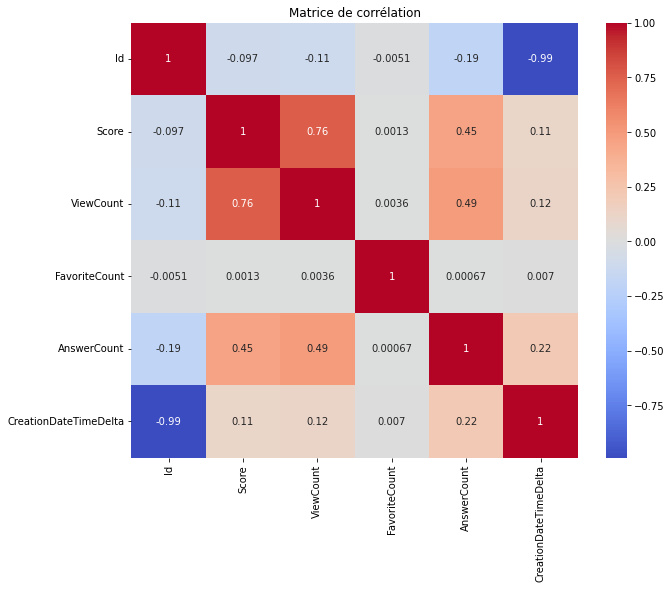

In [17]:
# Sélectionner uniquement les colonnes numériques
numeric_columns = data.select_dtypes(include=['int64', 'float64'])

# Calculer la matrice de corrélation
correlation_matrix = numeric_columns.corr()

# Afficher la matrice de corrélation avec un heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Matrice de corrélation")

# Afficher le graphique
plt.show()

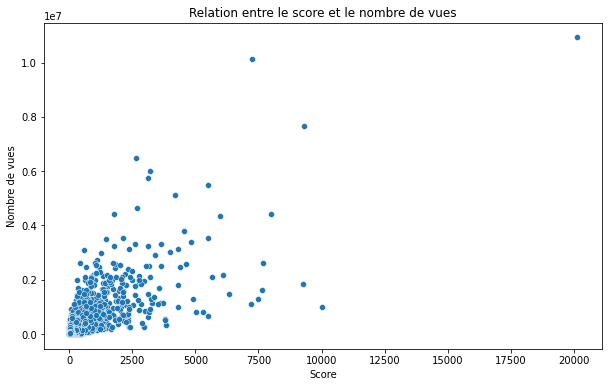

In [18]:
# graphique de dispersion
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='Score', y='ViewCount')
plt.xlabel("Score")
plt.ylabel("Nombre de vues")
plt.title("Relation entre le score et le nombre de vues")

# Afficher le graphique
plt.show()

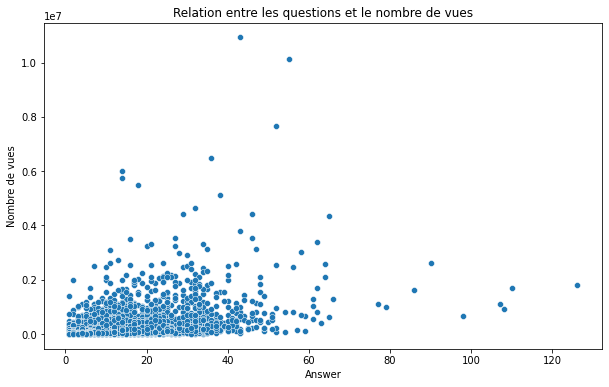

In [19]:
# graphique de dispersion
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='AnswerCount', y='ViewCount')
plt.xlabel("Answer")
plt.ylabel("Nombre de vues")
plt.title("Relation entre les questions et le nombre de vues")

# Afficher le graphique
plt.show()

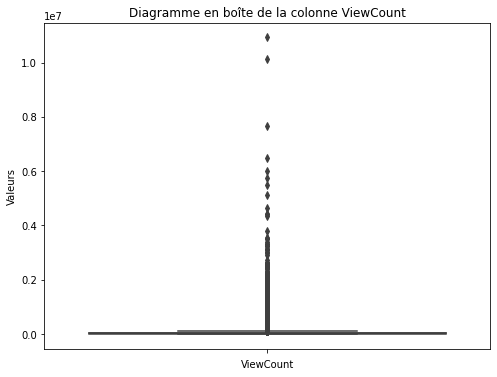

In [20]:
plot_boxplot(data, 'ViewCount')

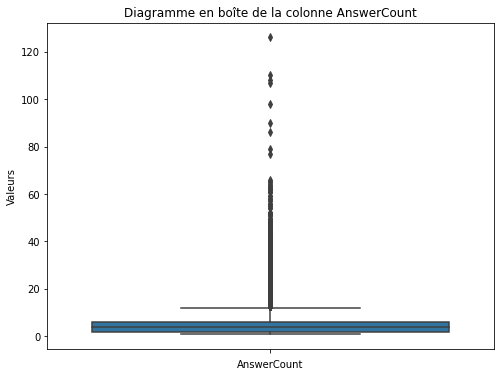

In [21]:
plot_boxplot(data, 'AnswerCount')

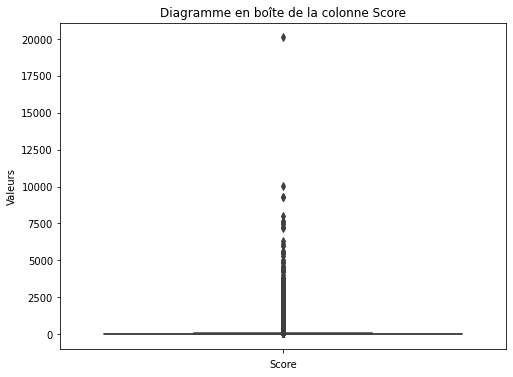

In [22]:
plot_boxplot(data, 'Score')

### Nettoyage

In [23]:
# application de la transformation logarithmique sur les colonnes ViewCount, AnswerCount et Score
data['ViewCount'] = np.log1p(data['ViewCount'])
data['AnswerCount'] = np.log1p(data['AnswerCount'])
data['Score'] = np.log1p(data['Score'])
# identification des seuils supérieurs pour chaque colonne (basé sur l'écart type)
viewcount_threshold = np.mean(data['ViewCount']) + 3 * np.std(data['ViewCount'])
answercount_threshold = np.mean(data['AnswerCount']) + 3 * np.std(data['AnswerCount'])
score_threshold = np.mean(data['Score']) + 3 * np.std(data['Score'])
# suppression des outliers
data = data[data['ViewCount'] <= viewcount_threshold]
data = data[data['AnswerCount'] <= answercount_threshold]
data = data[data['Score'] <= score_threshold]

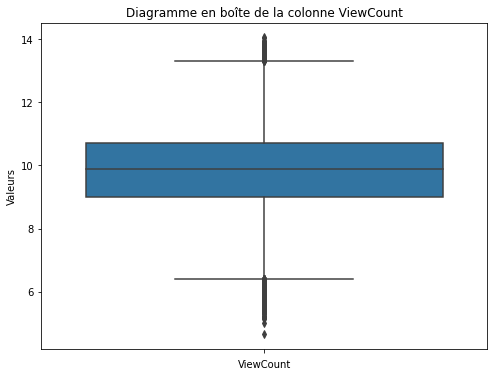

In [24]:
plot_boxplot(data, 'ViewCount')

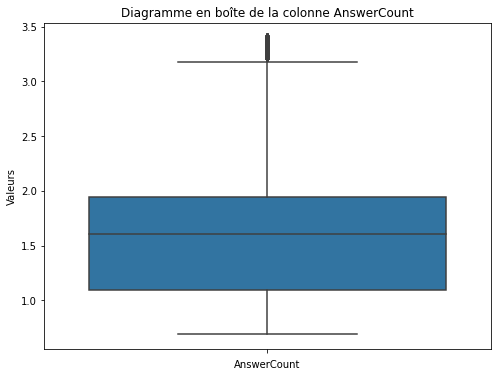

In [25]:
plot_boxplot(data, 'AnswerCount')

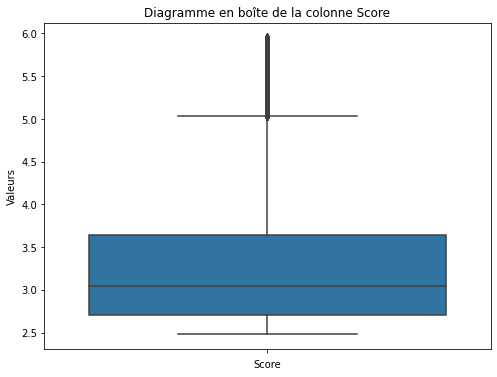

In [26]:
plot_boxplot(data, 'Score')

Affichon queques commentaires pour voir leur contenu

In [27]:
sample_size = 5

random_sample = data.sample(n=sample_size)

display_formatted_comments(random_sample, 'Body')

**Commentaire:**

<p>We recently attempted to break apart some of our Visual Studio projects into libraries, and everything seemed to compile and build fine in a test project with one of the library projects as a dependency. However, attempting to run the application gave us the following nasty run-time error message:</p>

<blockquote>
  <p>Run-Time Check Failure #0 - The value of ESP was not properly saved across a function call. This is usually a result of calling a function pointer declared with a different calling convention.</p>
</blockquote>

<p>We have never even specified calling conventions (__cdecl etc.) for our functions, leaving all the compiler switches on the default. I checked and the project settings are consistent for calling convention across the library and test projects.</p>

<p>Update: One of our devs changed the "Basic Runtime Checks" project setting from "Both (/RTC1, equiv. to /RTCsu)" to "Default" and the run-time vanished, leaving the program running apparently correctly. I do not trust this at all. Was this a proper solution, or a dangerous hack?</p>


--------------------------------------------------


**Commentaire:**

<p>I want to change the port number on which my website runs while debugging from Visual Studio. I am using Visual Studio 2012, and I am using ASP.NET MVC 4 for my projects I want to change the port. Random port or fixed anyone will work just want to change the port.</p>


--------------------------------------------------


**Commentaire:**

<p>I need to store the result of FireBase getValue method that is async by his own. I can't use something like "onPostExecute()" and, for my purpose, i can't execute all my operation "into onDataChange()" because i need some references in future time in other activities.</p>

<p>Here my snippet to retrieve data:</p>

<pre><code>    List&lt;Village&gt; villages = new LinkedList&lt;&gt;();
    Firebase ref = new Firebase("MYFIREBASEURL").child("village");
    ref.addValueEventListener(new ValueEventListener() {
        @Override
        public void onDataChange(DataSnapshot snapshot) {
            spinnerArray.clear();
            for (DataSnapshot postSnapshot : snapshot.getChildren()) {
                Village v = postSnapshot.getValue(Village.class);
                villages.add(v);
            }
        }

        @Override
        public void onCancelled(FirebaseError firebaseError) {
            System.out.println("The read failed: " + firebaseError.getMessage());
        }
    });
</code></pre>

<p>If i try to read villages out of "onDataChange" i have, naturally for his async life, null value. There is a way to ensure that onDataChange was called?.</p>


--------------------------------------------------


**Commentaire:**

<p>I cannot get session data from while in web api 2. I have verified that the cookie is sending in fiddler.</p>

<p>I know that web api 2 best practice is to be stateless, but due to requirements on a project it is now necessary to be state-full.</p>

<p>I have tried this link.
<a href="https://stackoverflow.com/questions/19758221/webapi-2-attribute-routing-enable-session-state">WebAPI 2 attribute routing enable session state</a></p>

<pre><code>var session = SessionStateUtility.GetHttpSessionStateFromContext(HttpContext.Current)
</code></pre>

<p>With the above solution I am getting a null exception on that function.</p>

<p>I also tried replicating the way of doing this the way you would in the old web api by modifying the requesthandler from the route, but that is not available in web api 2. </p>

<p>I currently set some session variables in mvc5. This works and the session stays, but anytime I am trying to use session while in web api 2 the below is null.</p>

<pre><code>HttpContext.Current.Session
</code></pre>


--------------------------------------------------


**Commentaire:**

<p>I'm working on a project where I have to access a set of Google Calendars using REST and working with Java.</p>

<p>The program, situated on a private non-Google server, periodically (via cron job) connects to the Google account, gets the list of Calendars linked to the account, gets the last month's events of each calendar, and returns an XML file containing all the information. The program should be able to execute and access calendars WITHOUT any user input. For the moment, the project specifies that the Calendar will just be read, not modified (so only GET/LIST calls will be made).</p>

<p>I have looked through the Google documentation and been over the sample codes using client libraries, and almost all examples given require OAuth 2.0 user consent before accessing calendar API. Even the REST API documentation pages require you activate OAuth 2.0 to return requested information (otherwise returning a HTTP 40X error code and JSON file containing error status and message).</p>

<p>How could I connect to the Google Calendar REST API to get the information I need, everything being done via REST calls, and without requiring user consent at the time of execution?</p>

<p>Or am I over-complicating things, and only require the 'Server Key', found in the Resgistered Apps part of the Google Cloud Console?<br>
Or am I requiring to use both OAuth and developer key? (I found someone mention it here under a question with the title : Google Calendar API v3 hardcoded credentials ; however, the question and solution were for PHP, and I don't know if something similar would be possible or necessary in Java).</p>

<ul>
<li>I did see the possibility of creating a JWT with a service account (with Google cloud console, register as a Web Application, and it's under 'certificate'), but I did not find how I would use this in conjunction with a REST call from a Java program.<br></li>
<li>The following link (<a href="http://aleksz-programming.blogspot.be/2012/11/google-calendar-api.html" rel="noreferrer">http://aleksz-programming.blogspot.be/2012/11/google-calendar-api.html</a>) says that it is possible to access information via 'Web server applications' or 'Installed applications', but doesn't go into detail. However, on the Google OAuth 2.0 documentation page, the 'Web server applications' part still requires user input &amp; consent. Which is true?<br></li>
<li>I also found this page (<a href="https://developers.google.com/accounts/docs/OAuth2Login" rel="noreferrer">https://developers.google.com/accounts/docs/OAuth2Login</a>), but failed to see how it could be used without using a user consent page.<br></li>
<li>I did see some references to a '2-legged OAuth'. But it seems that this is not a OAuth 2.0, but a version 1 was of doing things. Is it a possible solution for my project? If so, what information would I need from Google Cloud Console to get it working?</li>
</ul>

<p>I hope I have given enough information as to what I'm looking for, and also that this question hasn't been covered so far. I did research it, and didn't find anything close enough to what I was looking for.</p>

<p>I was unable to post more than 2 links (lacking reputation), but did look at the Google Calendar v3 REST API, as well as the page specifying the creation of a JWT.</p>


--------------------------------------------------


In [28]:
# nettoyer le body, joindre avec le titre et trouver ce qui est pertinent pour avoir un jeu de donné le plus proche de ce que l'on veut
# claissification multi-label
# détermination du model
# répondre aux questions du projet
# creation de l'API 

### Préparation des données

#### Nettoyage du champ body

In [29]:
#!pip install imblearn

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Supprimer les valeurs manquantes dans les colonnes 'Body' et 'Title'
data = data.dropna(subset=['Body', 'Title'])

# Nettoyage du champ 'Body' et 'Title'
data['cleaned_body'] = data['Body'].apply(clean_text)
data['cleaned_title'] = data['Title'].apply(clean_text)

# Concaténation du champ 'Body' et 'Title' pour l'entrée du modèle
data['combined_text'] = data['cleaned_body'] + ' ' + data['cleaned_title']

# Sélection des colonnes pertinentes pour la classification multi-label
X = data['combined_text']
#y = data['Tags'].apply(lambda tags: tags.split('<')[1:]).apply(lambda tags: [tag[:-1] for tag in tags])
y = data['Tags'].apply(lambda tags: tags.split(','))

unique_tags = set([tag for tags in y for tag in tags])
print("Tags uniques:", unique_tags)

# Transformer les tags en format multi-label binaire
mlb = MultiLabelBinarizer()
y_bin = mlb.fit_transform(y)

y_bin = mlb.fit_transform(y)
print("Shape de y_bin:", y_bin.shape)



# Concaténation du champ 'Body' et 'Title' pour l'entrée du modèle
data['combined_text'] = data['cleaned_body'] + ' ' + data['cleaned_title']



# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.2, random_state=42)

# Création d'une instance du vecteur TF-IDF
vectorizer = TfidfVectorizer()

# Transformation du texte en vecteurs de caractéristiques TF-IDF
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Sur-échantillonnage SMOTE pour chaque colonne de la matrice des cibles
X_train_resampled, y_train_resampled = [], []

# Vérification de la distribution des classes
class_counts = np.sum(y_train, axis=0)
print("Nombre d'échantillons par classe:", class_counts)

# Effectuer un sous-échantillonnage de la classe majoritaire
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_tfidf, y_train)

# Utiliser SMOTE pour sur-échantillonner les données équilibrées
smote = SMOTE(random_state=42, k_neighbors=2)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_resampled, y_train_resampled)

# Concaténer les ensembles de données suréchantillonnés
X_train_resampled = np.hstack(X_train_resampled)
y_train_resampled = np.column_stack(y_train_resampled)

# Réorganiser les dimensions de X_train_resampled
X_train_resampled = np.reshape(X_train_resampled, (X_train_resampled.shape[0], 1))


# initialisation modèle de classification multi-label
#model = MultiOutputClassifier(LinearSVC())

# Entraînement modèle sur l'ensemble d'entraînement sur-échantillonné
#model.fit(X_train_resampled, y_train_resampled)

# Faire des prédictions sur l'ensemble de test
#y_pred = model.predict(X_test_tfidf)

# performances
#report = classification_report(y_test, y_pred, target_names=mlb.classes_)
#print(report)

### Gengine

1. Prétraitement des données :

  * Nettoyer et prétraitez les données en supprimant les valeurs manquantes et en effectuant d'autres étapes de nettoyage.
  * Diviser les données en ensembles d'entraînement et de test.
  
2. Entraînement du modèle Word2Vec :

  * Utiliser Gensim pour entraîner un modèle Word2Vec sur les données d'entraînement prétraitées.
  * Définir les paramètres du modèle, tels que la dimensionnalité des vecteurs, la fenêtre contextuelle, etc.
  * Entraîner le modèle Word2Vec sur les données d'entraînement.
  
3. Représentation vectorielle des mots :

  * Pour chaque commentaire, représenter chaque mot comme un vecteur en utilisant le modèle Word2Vec entraîné.
  * Agréger les vecteurs de mots pour représenter chaque commentaire sous forme de vecteur.
  
4. Classification multi-label :

  * Utiliser les commentaires représentés sous forme de vecteurs comme données d'entrée pour le modèle de classification multi-label.
  * Entraîner le modèle de classification sur les données d'entraînement et évaluee ses performances sur les données de test.

In [ ]:
from gensim.models import Word2Vec
from sklearn.svm import LinearSVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report
import numpy as np

# Tokenization and preprocessing of the data
sentences = [text.split() for text in data['combined_text']]

# Train Word2Vec model
model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Vectorize comments using Word2Vec embeddings
X_vec = []
for sentence in sentences:
    vec = np.zeros(model.vector_size)
    count = 0
    for word in sentence:
        if word in model.wv:
            vec += model.wv[word]
            count += 1
    if count > 0:
        vec /= count
    X_vec.append(vec)

# Multi-label classification with LinearSVC
linear_svc = LinearSVC()
model = MultiOutputClassifier(linear_svc)
model.fit(X_vec, y_bin)

# Vectorize test comments using Word2Vec embeddings
X_test_vec = []
test_sentences = [text.split() for text in X_test]
for sentence in test_sentences:
    vec = np.zeros(model.estimators_[0].coef_.shape[1])
    count = 0
    for word in sentence:
        if word in model.estimators_[0].estimator_.wv:
            vec += model.estimators_[0].estimator_.wv[word]
            count += 1
    if count > 0:
        vec /= count
    X_test_vec.append(vec)

# Predict tags for test comments
y_pred = model.predict(X_test_vec)

# Performance evaluation
report = classification_report(y_test, y_pred, target_names=mlb.classes_)
print(report)


In [ ]:
# sauvegarde du modele gengine
import joblib

#Enregistrement du modèle dans un fichier
joblib.dump(model, './models/classification_genginemodel_fabrice_deprez_OPP5_062023.pkl')

### PILDI10

1. Performances de classification : Évaluer la précision, le rappel, la mesure F1 ou toute autre mesure appropriée pour évaluer les performances de l'approche supervisée. 
   Comparer ces performances avec celles de l'approche non supervisée pour voir quelle méthode fonctionne mieux pour la tâche de suggestion de tags.

2. Interprétabilité des résultats : Analyser les thèmes extraits par PILDI10 et examinez s'ils correspondent aux tags réels. 
   Comparer cela avec les tags prédits par l'approche supervisée pour voir si les thèmes extraits sont informatifs et pertinents.

3. Évolutivité : Considérer la capacité des deux approches à gérer de grandes quantités de données et à s'adapter à de nouveaux commentaires. 
   L'approche supervisée nécessite un ensemble de données annotées pour l'entraînement, tandis que l'approche non supervisée peut être plus flexible en n'ayant pas besoin d'annotations.

4. Coût de l'étiquetage : Évaluer le temps et les ressources nécessaires pour étiqueter les données pour l'approche supervisée par rapport à l'extraction de thèmes automatique de l'approche    non supervisée. L'approche non supervisée peut être plus avantageuse si vous disposez de grandes quantités de données à étiqueter.

In [ ]:
from pildi10 import PILDI10
from sklearn.metrics import classification_report

# Preprocessing and tokenization of the data
# ...

# Initialize and fit PILDI10 model
model = PILDI10()
model.fit(X_train, y_train)

# Predict tags for test data
y_pred = model.predict(X_test)

# Performance evaluation
report = classification_report(y_test, y_pred, target_names=mlb.classes_)
print(report)


### Comparaison
    Pour comparer les deux modèles, on peut évaluer leurs performances à l'aide des mêmes métriques de classification, 
    telles que la précision, le rappel et la mesure F1. 

In [ ]:
#Enregistrement du modèle dans un fichier
joblib.dump(model, './models/classificationpildi10model_fabrice_deprez_OPP5_062023.pkl')

### Comparaison

Pour comparer les deux modèles, on peut évaluer leurs performances à l'aide des mêmes métriques de classification, telles que la précision, le rappel et la mesure F1. 

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Évaluer les performances du modèle gengine
y_pred_gengine = model_gengine.predict(X_test_vec)
precision_gengine = precision_score(y_test, y_pred_gengine, average='micro')
recall_gengine = recall_score(y_test, y_pred_gengine, average='micro')
f1_gengine = f1_score(y_test, y_pred_gengine, average='micro')

# Évaluer les performances du modèle PILDI10
y_pred_pildi10 = model_pildi10.predict(X_test_counts)
precision_pildi10 = precision_score(y_test, y_pred_pildi10, average='micro')
recall_pildi10 = recall_score(y_test, y_pred_pildi10, average='micro')
f1_pildi10 = f1_score(y_test, y_pred_pildi10, average='micro')

# Afficher les performances des deux modèles
print("Performances du modèle gengine :")
print("Précision :", precision_gengine)
print("Rappel :", recall_gengine)
print("Mesure F1 :", f1_gengine)

print("\nPerformances du modèle PILDI10 :")
print("Précision :", precision_pildi10)
print("Rappel :", recall_pildi10)
print("Mesure F1 :", f1_pildi10)

### Simulation

In [ ]:
# Sélection d'un enregistrement du DataFrame
sample = data.sample(1)

# Récupération du titre et du corps de la question
title = sample['Title'].values[0]
body = sample['Body'].values[0]

# Nettoyage du titre et du corps
cleaned_title = clean_text(title)
cleaned_body = clean_text(body)

# Concaténation du titre et du corps pour l'entrée du modèle
combined_text = cleaned_body + ' ' + cleaned_title

# Vectorisation du texte
text_vectorized = vectorizer.transform([combined_text])

# Prédiction des tags
predicted_tags = classifier.predict(text_vectorized)
predicted_tags = mlb.inverse_transform(predicted_tags)

print("Question:")
print("Title:", title)
print("Body:", body)
print()
print("Predicted Tags:", predicted_tags)


# simplifier les tags pour n'avoir par exemple django a la place django-1.7
# il faut faire disparaitre les versions car si par exemple dans un texte on a 2 version de langage, on va se retrouver avec 2 tags alors qu'un seul suffit